In [3]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DXG Historical Data 1_6.csv')

In [5]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)
time_step = 100

x, y = create_dataset(df1, time_step)

X_train = x[:train_size-100]
X_test = x[train_size-100:]
y_train = y[:train_size-100]
ytest = y[train_size-100:]

In [10]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [11]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
19/19 [==============================] - 6s 112ms/step - loss: 0.0342 - val_loss: 0.0102
Epoch 2/100
19/19 [==============================] - 1s 77ms/step - loss: 0.0060 - val_loss: 5.3615e-04
Epoch 3/100
19/19 [==============================] - 1s 74ms/step - loss: 0.0014 - val_loss: 3.2055e-04
Epoch 4/100
19/19 [==============================] - 1s 77ms/step - loss: 7.4865e-04 - val_loss: 3.2516e-04
Epoch 5/100
19/19 [==============================] - 1s 73ms/step - loss: 6.8523e-04 - val_loss: 3.0327e-04
Epoch 6/100
19/19 [==============================] - 1s 73ms/step - loss: 6.3869e-04 - val_loss: 2.8936e-04
Epoch 7/100
19/19 [==============================] - 2s 87ms/step - loss: 6.1109e-04 - val_loss: 3.0339e-04
Epoch 8/100
19/19 [==============================] - 2s 132ms/step - loss: 5.9498e-04 - val_loss: 2.7947e-04
Epoch 9/100
19/19 [==============================] - 2s 96ms/step - loss: 5.7408e-04 - val_loss: 2.7351e-04
Epoch 10/100
19/19 [======================

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

10/10 [==============================] - 0s 12ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [15]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 16650.391776206914


In [16]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99845068028232
Testing MAE: 16372.120715025609


In [17]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.2492537498474121], [0.24731437861919403], [0.24532616138458252], [0.24331429600715637], [0.24128934741020203], [0.23925653100013733], [0.23721957206726074], [0.2351815104484558], [0.23314480483531952], [0.23111170530319214], [0.22908399999141693], [0.2270633429288864], [0.2250511348247528], [0.22304868698120117], [0.22105704247951508], [0.21907728910446167], [0.21711021661758423], [0.21515658497810364], [0.21321704983711243], [0.21129204332828522], [0.20938214659690857], [0.20748767256736755], [0.20560899376869202], [0.20374633371829987], [0.201899915933609], [0.20006981492042542], [0.1982562094926834], [0.1964591145515442], [0.19467860460281372], [0.19291463494300842], [0.1911672204732895], [0.18943625688552856], [0.1877216100692749], [0.1860232949256897], [0.18434110283851624], [0.18267494440078735], [0.18102462589740753], [0.179390087723732], [0.17777104675769806], [0.17616745829582214], [0.17457902431488037], [0.17300567030906677], [0.17144715785980225], [0.16990327835083008], 

In [18]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[16711.96685977],
       [16634.37087149],
       [16554.82051054],
       [16474.32396611],
       [16393.30395029],
       [16311.96913619],
       [16230.46857603],
       [16148.9238964 ],
       [16067.43347179],
       [15986.08732972],
       [15904.95701526],
       [15824.10870759],
       [15743.59845036],
       [15663.47870994],
       [15583.79122094],
       [15504.57950663],
       [15425.87516606],
       [15347.7086059 ],
       [15270.10605933],
       [15193.0848164 ],
       [15116.66812927],
       [15040.86851833],
       [14965.70088878],
       [14891.17418377],
       [14817.29734643],
       [14744.0733578 ],
       [14671.50937239],
       [14599.60598641],
       [14528.3661809 ],
       [14457.78816724],
       [14387.87254163],
       [14318.61513062],
       [14250.01056832],
       [14182.05945094],
       [14114.75343156],
       [14048.08893293],
       [13982.05820432],
       [13916.65886091],
       [13851.87957472],
       [13787.71855713],


In [19]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [20]:
print(y_pred_with_test_data.shape)
test_data.shape

(420,)


(320, 1)

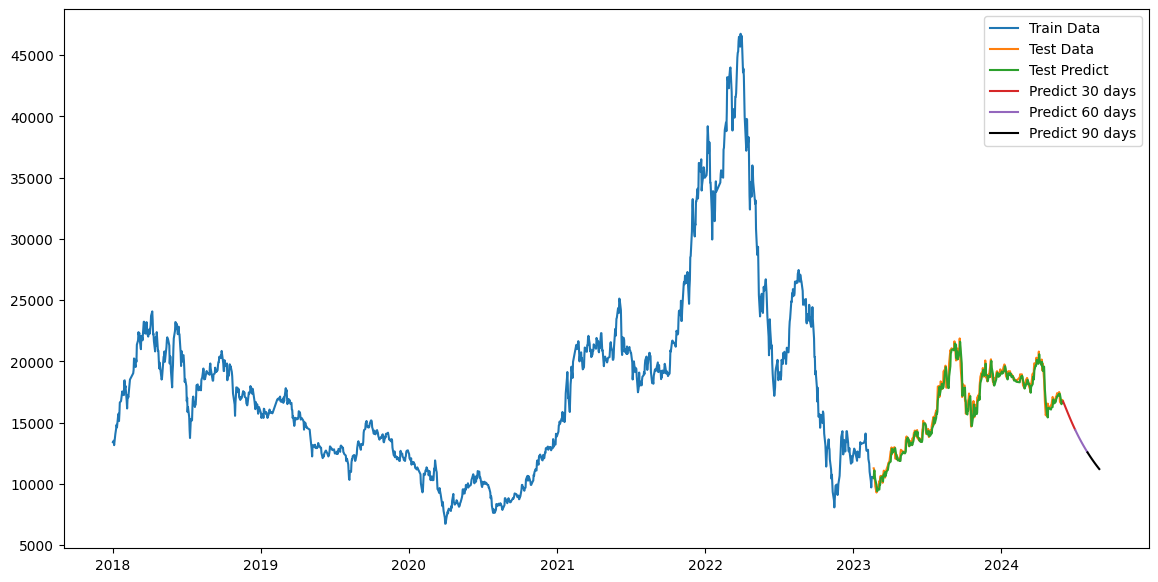

In [22]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred)], y_pred, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=30)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=30)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[30:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[60:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()